# **Modelos Avanzados de Aprendizaje Automático I**


**Rafael Balseiro Couceiro** <br>
**Iván Mandayo Lagoa** <br>
**Alba ... ...**

# **Práctica 2: Reconocimiento de movimiento a partir de sensores de smartphones**

In [1]:
# Check enviroment
using Pkg

In [2]:
# Import necessary libraries
using DataFrames: groupby, combine, select!, Not, DataFrame, ncol, nrow, disallowmissing!
using MLJ
using MLJLinearModels
using MLJBase
using CSV
using Statistics
using Plots
using Random
using StatsBase
using IterTools
using Impute
using DataFrames
using StatsPlots
using CategoricalArrays
using Tables
using Plots.Measures

In [3]:
include("../src/filterWrappers.jl")
include("../src/dimReduction.jl")
include("../src/modelFactory.jl")
include("../src/experimentLab.jl")
include("../src/scaler.jl")
include("../src/resultAnalysis.jl")
include("../src/hypothesisTest.jl")

using .FilteringReduction: PearsonSelector, SpearmanSelector, KendallSelector, ANOVASelector, MutualInfoSelector, RFELogistic
using .ProyectionReduction: get_lda_model, get_pca_model, get_ica_model
using .ModelFactory: get_knn_model, 
                        get_svm_model, 
                        get_mlp_model, 
                        get_bagging_knn_model, 
                        get_evotree_model, 
                        get_adaboost_model, 
                        get_rf_model, 
                        get_xgboost_model, 
                        get_lightgbm_model, 
                        get_catboost_model,
                        get_voting_classifier,
                        get_stacking_model,
                        get_individual_wise_CV,
                        IndividualWiseCV

using .ExperimentLab: run_experiment_crossvalidation, History, run_experiment_holdout
using .CustomScalers: MinMaxScaler
using .ResultAnalysis: display_cv_table, plot_cv_results, display_holdout_table, display_confussion_matrix, process_feature_importance
using .StatisticalTests: auto_compare_models

[ Info: For silent loading, specify `verbosity=0`. 


import MLJLinearModels ✔


[ Info: lib_lightgbm found in system dirs!


In [4]:
Random.seed!(104) 

TaskLocalRNG()

In [5]:
output_dir = joinpath("..", "results")

if !isdir(output_dir)
    mkpath(output_dir)
    println("Directorio creado: $output_dir")
end

## **Preparación de los datos**

### **1. Carga y unificación de los datos**

In [6]:
# Ruta raíz de los datos
DATA_PATH = "../data"

# Recorrer todos los directorios y subdirectorios, y extraer archivos CSV
csv_files = filter(f -> endswith(f, ".csv"), 
                   [joinpath(dir, file) for (dir, _, files) in walkdir(DATA_PATH) for file in files])

# Cargar todos los CSVs en un vector de DataFrames
dataframes = CSV.File.(csv_files) .|> DataFrame

# Concatenar todos los DataFrames en uno solo
full_dataset = vcat(dataframes...)

# Descripción básica
total_features = size(full_dataset, 2)
total_instances = size(full_dataset, 1)
total_individuals = size(unique(full_dataset.subject), 1)
total_targets = size(unique(full_dataset.Activity), 1)

println("Número de variables: ", total_features)
println("Número de instancias: ", total_instances)
println("Número de individuos: ", total_individuals)
println("Número de clases de salida: ", total_targets)



Número de variables: 563
Número de instancias: 10299
Número de individuos: 30
Número de clases de salida: 6


### **2. Análisis de missing values**

Examinaremos los valores faltantes del dataset para establecer una **estrategia** adaptada para su **tratamiento**.

In [7]:
# Nombres de columnas
cols = names(full_dataset)
missing_counts = count.(ismissing, eachcol(full_dataset))

missing_percent = Dict(cols[i] => 100 * missing_counts[i] / total_instances for i in eachindex(cols))

# Porcentaje de missing total
total_missing_percent = 100 * sum(missing_counts) / (total_instances * ncol(full_dataset))

# Mostrar resultados
for (col, pct) in sort(collect(missing_percent), by=x->x[2], rev=true)
    if pct > 0.0
        println(col, ": ", round(pct, digits=2), "%")
    end
end

println("\nTotal Missing Values (%): ", round(total_missing_percent, digits=2), "%")

tBodyGyroMag-mad(): 10.03%
tBodyGyroMag-iqr(): 10.03%
fBodyAcc-mad()-Y: 10.02%
fBodyAccJerk-mean()-X: 10.02%
tGravityAccMag-std(): 10.0%
tBodyAccJerk-entropy()-Y: 10.0%
tBodyAccMag-max(): 10.0%
fBodyBodyGyroMag-iqr(): 10.0%
tBodyAccJerk-energy()-X: 10.0%
fBodyAcc-std()-X: 10.0%
tGravityAccMag-entropy(): 10.0%
fBodyAcc-maxInds-Y: 9.99%
tBodyAccJerkMag-arCoeff()2: 9.99%
tGravityAcc-arCoeff()-X,3: 9.99%
fBodyGyro-energy()-Y: 9.99%
fBodyGyro-bandsEnergy()-49,56.1: 9.99%
fBodyAccJerk-bandsEnergy()-1,8.1: 9.99%
fBodyAccJerk-bandsEnergy()-1,8: 9.99%
fBodyAccMag-max(): 9.99%
tGravityAcc-mad()-Z: 9.99%
tBodyGyroJerk-arCoeff()-Z,2: 9.99%
tBodyGyro-mean()-Z: 9.99%
fBodyAcc-bandsEnergy()-25,32.2: 9.99%
tBodyGyroJerkMag-arCoeff()1: 9.99%
fBodyAcc-kurtosis()-Y: 9.99%
tBodyAccJerk-arCoeff()-X,4: 9.99%
fBodyGyro-mean()-X: 9.99%
tBodyAcc-correlation()-X,Y: 9.99%
fBodyAccJerk-bandsEnergy()-49,56.2: 9.99%
fBodyAccJerk-bandsEnergy()-9,16.2: 9.99%
fBodyAccJerk-bandsEnergy()-1,24: 9.99%
fBodyAcc-min()-Z: 9.

In [8]:
# Threshold
threshold = 5.0

# Convertimos el diccionario a DataFrame
df_missing = DataFrame(Feature = collect(keys(missing_percent)),
                       MissingPct = collect(values(missing_percent)))

# Categorizar
high_missing = df_missing[df_missing.MissingPct .>= threshold, :]
low_missing  = df_missing[(df_missing.MissingPct .> 0) .& (df_missing.MissingPct .< threshold), :]
no_missing   = df_missing[df_missing.MissingPct .== 0, :]

# Crear tabla resumen
summary_table = DataFrame(
    Category = ["High Missing (>=5%)", "Low Missing (>0% & <5%)", "No Missing (0%)"],
    NumVariables = [nrow(high_missing), nrow(low_missing), nrow(no_missing)],
    MeanMissingPct = [mean(high_missing.MissingPct),
                      mean(low_missing.MissingPct),
                      mean(no_missing.MissingPct)],
    StdMissingPct = [std(high_missing.MissingPct),
                     std(low_missing.MissingPct),
                     std(no_missing.MissingPct)]
)

println(summary_table)


3×4 DataFrame
 Row │ Category                 NumVariables  MeanMissingPct  StdMissingPct 
     │ String                   Int64         Float64         Float64       
─────┼──────────────────────────────────────────────────────────────────────
   1 │ High Missing (>=5%)                56       9.9949        0.00917645
   2 │ Low Missing (>0% & <5%)           119       0.0201537     0.00921659
   3 │ No Missing (0%)                   388       0.0           0.0


### **3. Tratamiento de missing values**

Como hemos visto hay varias features con **valores faltantes**, nuestra estrategia de tratamiento será la siguiente:

- Se asume que los valores nulos siguen un esquema **MCAR** (*Missing Completely at Random*)
- **Threshold**: 5%.
- Si *null_percentage* >= 5%: eliminación de dicha feature.
- Sino si *null_percentage* < 5%: imputación por interpolación individual-wise.

In [9]:
function impute_MCAR(df::DataFrame, missing_percent::Dict{String, Float64}, threshold::Float64=5.0)

    df_clean = deepcopy(df)

    cols = names(df_clean)
    # Reutilizamos el diccionario pasado como argumento
    pct_missing = [missing_percent[col] for col in cols]

    # Identificación de columnas
    to_drop   = cols[pct_missing .>= threshold]
    to_impute = cols[(pct_missing .> 0.0) .& (pct_missing .< threshold)]

    # Eliminar columnas con exceso de missings
    select!(df_clean, Not(to_drop))

    # Informe
    imputed_cols = Dict{String,String}()

    # === IMPUTACIÓN POR INDIVIDUO (Interpolación Temporal) ===
    # Agrupamos por sujeto (vista)
    gdf = groupby(df_clean, :subject)

    for col in to_impute
        
        # Iteramos sobre los grupos (individuos)
        for subdf in gdf
            # Aplicar interpolación
            subdf[!, col] .= Impute.interp(subdf[!, col]) |> Impute.locf |> Impute.nocb
        end

        # Registrar imputación
        imputed_cols[col] = "linear_interpolation_by_subject"
    end

    # Eliminar el tipo Union{Missing, T} que puede fallar en el pipeline
    DataFrames.disallowmissing!(df_clean)

    # Reporte final
    report = Dict(
        "eliminated_columns" => to_drop,
        "imputed_columns"    => keys(imputed_cols),
        "num_eliminated"     => length(to_drop),
        "num_imputed"        => length(imputed_cols)
    )

    return df_clean, report
end

impute_MCAR (generic function with 2 methods)

Ahora, ya diseñado el pipeline de limpieza de valores nulos, lo aplicaremos:

In [10]:
# Suponiendo que full_dataset y missing_percent ya están definidos
threshold = 5.0
clean_df, imputation_report = impute_MCAR(full_dataset, missing_percent, threshold)

println("Dropped features: ", imputation_report["num_eliminated"])
println("Imputed features: ", imputation_report["num_imputed"])
println("New feature space dimension: ", size(clean_df, 2))

Dropped features: 56
Imputed features: 119
New feature space dimension: 507


Podemos observar que el número de columnas, tanto eliminadas como imputadas **coincide** con el análisis hecho con el dataset completo anteriormente.

Para asegurarnos por completo, contaremos el número de **missing values**, puediendo asegurar que es ahora **0**.

In [11]:
# Contar la cantidad de missing values
missing_values = sum(count.(ismissing, eachcol(clean_df)))
println("\nTotal Missing Values: ", missing_values)


Total Missing Values: 0


### **4. Partición del conjunto**

Generaremos las divisiones **holdout** y **crossvalidation** empleando una estrategia ***individual-wise** para una evaluación más **precisa** de los modelos.

- Para **crossvalidation**, no generaremos los conjuntos explícitamente, sino que calcularemos qué índices pertenecen a cada **fold**.
- Esto permite **compatibilidad** total con **MLJ**.

In [12]:
function train_test_split(df::DataFrame, test_size::Float64=0.1)

    Random.seed!(104) 
    individuals = unique(df.subject)
    Random.shuffle!(individuals)
    n_test = Int(floor(length(individuals) * test_size))
    test_individuals = individuals[1:n_test]
    train_individuals = individuals[(n_test+1):end]
    train_df = df[in.(df.subject, Ref(train_individuals)), :]
    test_df = df[in.(df.subject, Ref(test_individuals)), :]
    return (train_df, test_df)

end

train_test_split (generic function with 2 methods)

In [13]:
function cross_validation_folds(df::DataFrame, k::Int=5)
    
    Random.seed!(104)
    
    # 1. Asignación aleatoria de individuos a folds
    folds = 1:k
    individuals = unique(df.subject)
    k_folds = repeat(folds, Int(ceil(length(individuals)/k))) 
    k_folds = k_folds[1:length(individuals)] 
    k_folds = shuffle!(k_folds) 

    # Mapeo: ID Sujeto -> Número de Fold (1..k)
    individual_to_fold = Dict(ind => fold for (ind, fold) in zip(individuals, k_folds))
    
    # 2. Generar vector de asignación por fila
    # Para cada fila del DF, miramos a qué fold pertenece su sujeto
    row_fold_assignments = [individual_to_fold[s] for s in df.subject]
    
    # 3. Crear tuplas de índices (Train, Test)
    cv_folds_indices = Vector{Tuple{Vector{Int}, Vector{Int}}}()
    
    for i in 1:k
        # Test: Filas cuyo sujeto cayó en el fold 'i'
        test_idx = findall(row_fold_assignments .== i)
        
        # Train: Filas cuyo sujeto cayó en cualquier OTRO fold
        train_idx = findall(row_fold_assignments .!= i)
        
        push!(cv_folds_indices, (train_idx, test_idx))
    end
    
    return cv_folds_indices    
end

cross_validation_folds (generic function with 2 methods)

In [14]:
train, test = train_test_split(clean_df, 0.1)

# Verificar datasets
println("Individuals in train set: ", length(unique(train.subject)))
println("Individuals in test set: ", length(unique(test.subject)), " | ", unique(test.subject))

println("Train set size: ", size(train))
println("Test set size: ", size(test))

Individuals in train set: 27
Individuals in test set: 3 | [25, 18, 22]
Train set size: (9205, 507)
Test set size: (1094, 507)


In [15]:
# --- Cross-Validation Folds Verification ---

# Generate folds (assuming 'train' DataFrame and 'cross_validation_folds' function exist)
folds = cross_validation_folds(train, 5)

println("CROSSVALIDATION CHECK (INDIVIDUAL-WISE)")
println("="^80)

# Iterating through fold tuples: [(train_idx, test_idx), ...]
for (i, (train_idx, test_idx)) in enumerate(folds)
    
    # Materialize data subsets using indices
    fold_train = train[train_idx, :]
    fold_test  = train[test_idx, :]
    
    # Extract unique subjects in each partition
    subjects_train = sort(unique(fold_train.subject))
    subjects_test  = sort(unique(fold_test.subject))
    
    # Check for intersection (Data Leakage)
    leakage = intersect(subjects_train, subjects_test)
    
    # Print Fold Report
    println("\n[Fold $i]")
    println("  Test Set:       Dimensions: $(size(fold_test))  | Subjects: $subjects_test")
    
    println("-"^80)
end

println("Verification completed.")

CROSSVALIDATION CHECK (INDIVIDUAL-WISE)

[Fold 1]
  Test Set:       Dimensions: (2171, 507)  | Subjects: [6, 7, 16, 21, 24, 30]
--------------------------------------------------------------------------------

[Fold 2]
  Test Set:       Dimensions: (1947, 507)  | Subjects: [2, 9, 10, 13, 26, 29]
--------------------------------------------------------------------------------

[Fold 3]
  Test Set:       Dimensions: (1823, 507)  | Subjects: [1, 17, 20, 23, 28]
--------------------------------------------------------------------------------

[Fold 4]
  Test Set:       Dimensions: (1662, 507)  | Subjects: [3, 5, 12, 14, 27]
--------------------------------------------------------------------------------

[Fold 5]
  Test Set:       Dimensions: (1602, 507)  | Subjects: [4, 8, 11, 15, 19]
--------------------------------------------------------------------------------
Verification completed.


### **5. Exploratory Data Analysis**

Realizaremos un análisis básico de los datos que constará de:

- Exploración de la **distribución de las clases** a lo largo del dataset, lo cuál nos dará información sobre qué métricas emplear.
- **Visualización** de la proyección de los datos en un espacio de **baja dimensionalidad**.

In [16]:
theme(:wong)

In [ ]:
# Agregación global de clases
activity_counts = combine(groupby(train, :Activity), nrow => :Count)
sort!(activity_counts, :Count, rev=true) # Orden descendente 

# Preparación para heatmap
subj_activity_df = combine(groupby(train, [:subject, :Activity]), nrow => :Count)
pivot_df = unstack(subj_activity_df, :subject, :Activity, :Count, fill=0)
sort!(pivot_df, :subject) # Asegurar orden numérico de sujetos

# Extraer matriz y ejes para el plot
heatmap_matrix = Matrix(pivot_df[:, Not(:subject)])
activities_x   = names(pivot_df, Not(:subject))

# Forzar orden numérico de sujetos
subjects_y = pivot_df.subject
subjects_categorical = categorical(string.(subjects_y), levels=string.(subjects_y), ordered=true);

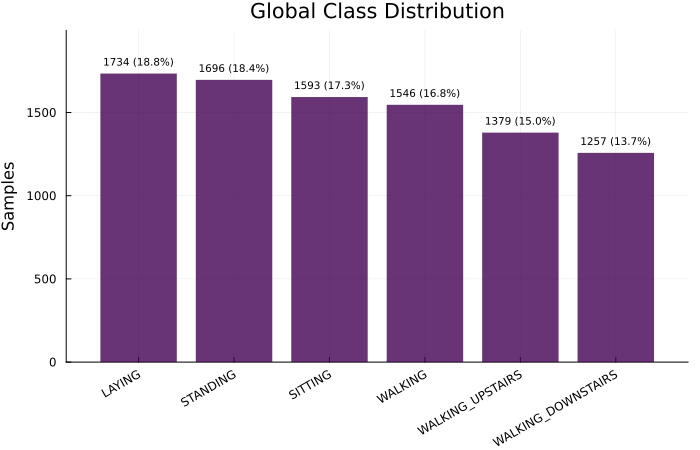

Imbalance Ratio: 1.38


In [ ]:
# Métricas de desbalanceo
min_c, max_c = extrema(activity_counts.Count)
imbalance_ratio = max_c / min_c

# Preparar etiquetas con porcentajes
total_n = sum(activity_counts.Count)
pcts = round.((activity_counts.Count ./ total_n) * 100, digits=1)
bar_labels = string.(activity_counts.Count, " (", pcts, "%)")

# Visualización
p_global = bar(
    activity_counts.Activity, activity_counts.Count,
    title = "Global Class Distribution",
    xlabel = "Activity Class", ylabel = "Samples",
    color = :viridis, alpha = 0.8, legend = false,
    xrotation = 30, linewidth = 0,
    ylim = (0, max_c * 1.15), # Margen superior para etiquetas
    size = (700, 450)
)

# Anotaciones sobre barras
anns = [(x, y + (max_c*0.02), text(lbl, 7, :black, :bottom)) 
        for (x, y, lbl) in zip(activity_counts.Activity, activity_counts.Count, bar_labels)]
annotate!(anns)

# Guardar plot
filename = "class_distribution.png"
filepath = joinpath(output_dir, filename)
savefig(p_global, filepath)

display(p_global)
println("Imbalance Ratio: $(round(imbalance_ratio, digits=2))")

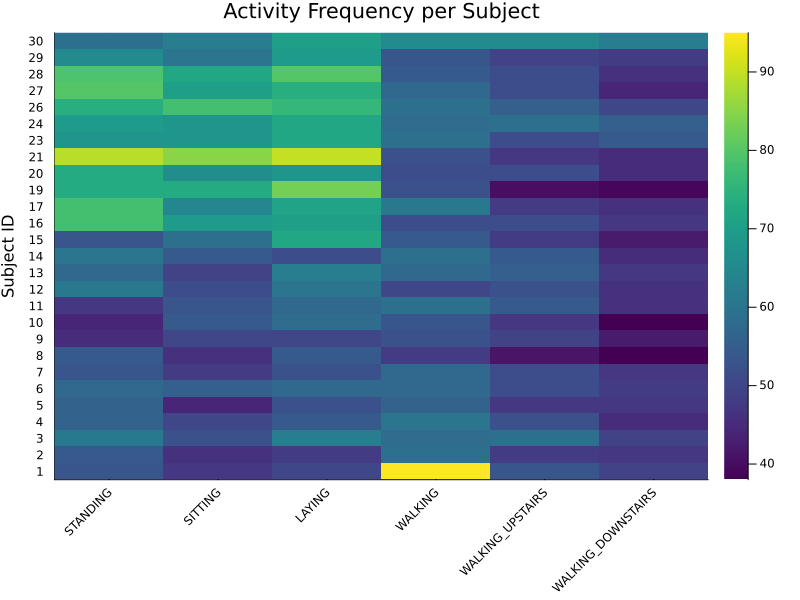

In [19]:
p_heatmap = heatmap(
    activities_x, subjects_categorical, heatmap_matrix,
    title  = "Activity Frequency per Subject",
    xlabel = "Activity", ylabel = "Subject ID",
    color = :viridis,
    xrotation = 45,
    size = (800, 600)
)

# Guardar plot
filename = "swise_class_distribution.png"
filepath = joinpath(output_dir, filename)
savefig(p_heatmap, filepath)

display(p_heatmap)

### **6. Conversión de datos para el pipeline**

Qué hacemos en esta fase del preprocesado:

- Convertir datos a **Tables** en lugar de DataFrames.
- Convertir el vector de labels a vector categórcio con **label encoding**.
- Lo haremos tanto para el conjunto de **entrenamiento** como para el conjunto de **test**.

In [16]:
# Feature Extraction (X)
# Transformación a ColumnTable (NamedTuple de vectores) para eficiencia en memoria
data_tbl = Tables.columntable(train)

# Filtrado de columnas de metadatos (ID y Target)
ignore_cols = (:subject, :Activity)
feature_cols = filter(k -> k ∉ ignore_cols, keys(data_tbl))

# Construcción de X como NamedTuple limpia
X_train = NamedTuple{feature_cols}(data_tbl)

# Target encoding con definicón explícita de orden semántico
activity_levels = [
    "LAYING", "SITTING", "STANDING", 
    "WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"
]

# Conversión a CategoricalArray ordenado
y_raw = Tables.getcolumn(data_tbl, :Activity)
y_train = categorical(y_raw, levels=activity_levels, ordered=true)

# Verificar tipos para pipeline
println("X Type:      ", typeof(X_train))
println("y Scitype:   ", scitype(y_train)) # Verificar compatibilidad con MLJ (OrderedFactor)
println("y Levels:    ", levels(y_train))

X Type:      @NamedTuple{var"tBodyAcc-mean()-X"::Vector{Float64}, var"tBodyAcc-mean()-Y"::Vector{Float64}, var"tBodyAcc-mean()-Z"::Vector{Float64}, var"tBodyAcc-std()-X"::Vector{Float64}, var"tBodyAcc-std()-Y"::Vector{Float64}, var"tBodyAcc-std()-Z"::Vector{Float64}, var"tBodyAcc-mad()-X"::Vector{Float64}, var"tBodyAcc-mad()-Y"::Vector{Float64}, var"tBodyAcc-mad()-Z"::Vector{Float64}, var"tBodyAcc-max()-X"::Vector{Float64}, var"tBodyAcc-max()-Y"::Vector{Float64}, var"tBodyAcc-max()-Z"::Vector{Float64}, var"tBodyAcc-min()-X"::Vector{Float64}, var"tBodyAcc-min()-Y"::Vector{Float64}, var"tBodyAcc-min()-Z"::Vector{Float64}, var"tBodyAcc-sma()"::Vector{Float64}, var"tBodyAcc-energy()-X"::Vector{Float64}, var"tBodyAcc-energy()-Y"::Vector{Float64}, var"tBodyAcc-energy()-Z"::Vector{Float64}, var"tBodyAcc-iqr()-X"::Vector{Float64}, var"tBodyAcc-iqr()-Y"::Vector{Float64}, var"tBodyAcc-iqr()-Z"::Vector{Float64}, var"tBodyAcc-entropy()-X"::Vector{Float64}, var"tBodyAcc-entropy()-Y"::Vector{Float64

In [17]:
# Feature Extraction (X)
# Transformación a ColumnTable (NamedTuple de vectores) para eficiencia en memoria
data_tbl = Tables.columntable(test)

# Filtrado de columnas de metadatos (ID y Target)
ignore_cols = (:subject, :Activity)
feature_cols = filter(k -> k ∉ ignore_cols, keys(data_tbl))

# Construcción de X como NamedTuple limpia
X_test = NamedTuple{feature_cols}(data_tbl)

# Target encoding con definicón explícita de orden semántico
activity_levels = [
    "LAYING", "SITTING", "STANDING", 
    "WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"
]

# Conversión a CategoricalArray ordenado
y_raw = Tables.getcolumn(data_tbl, :Activity)
y_test = categorical(y_raw, levels=activity_levels, ordered=true)

# verificar datos para pipeline
println("X Type:      ", typeof(X_test))
println("y Scitype:   ", scitype(y_test)) 
println("y Levels:    ", levels(y_test))

X Type:      @NamedTuple{var"tBodyAcc-mean()-X"::Vector{Float64}, var"tBodyAcc-mean()-Y"::Vector{Float64}, var"tBodyAcc-mean()-Z"::Vector{Float64}, var"tBodyAcc-std()-X"::Vector{Float64}, var"tBodyAcc-std()-Y"::Vector{Float64}, var"tBodyAcc-std()-Z"::Vector{Float64}, var"tBodyAcc-mad()-X"::Vector{Float64}, var"tBodyAcc-mad()-Y"::Vector{Float64}, var"tBodyAcc-mad()-Z"::Vector{Float64}, var"tBodyAcc-max()-X"::Vector{Float64}, var"tBodyAcc-max()-Y"::Vector{Float64}, var"tBodyAcc-max()-Z"::Vector{Float64}, var"tBodyAcc-min()-X"::Vector{Float64}, var"tBodyAcc-min()-Y"::Vector{Float64}, var"tBodyAcc-min()-Z"::Vector{Float64}, var"tBodyAcc-sma()"::Vector{Float64}, var"tBodyAcc-energy()-X"::Vector{Float64}, var"tBodyAcc-energy()-Y"::Vector{Float64}, var"tBodyAcc-energy()-Z"::Vector{Float64}, var"tBodyAcc-iqr()-X"::Vector{Float64}, var"tBodyAcc-iqr()-Y"::Vector{Float64}, var"tBodyAcc-iqr()-Z"::Vector{Float64}, var"tBodyAcc-entropy()-X"::Vector{Float64}, var"tBodyAcc-entropy()-Y"::Vector{Float64

## **Visualización de los datos**

Antes de comenzar con el entrenamiento:

- Procedemos a **visualizar** los datos en dos dimensiones para hacernos una idea de la clusterización de las clases.
- Lo haremos mediante diferentes **técnicas**, por lo que hay que tenerlas en cuenta para interpretar los resultados.
- Sin embargo, nos pueden dar una **aproximación semántica** sobre la **separación de clases**.

In [ ]:
"""
    Esta fucnión nos permite crear un pequeño pipeline adaptado a la 
    visualización de los datos previamente normalizados (evitar contraste entre dimensiones).
"""

function generate_2d_projection(normalizer, projector, X_train, y_train, X_test)
    
    pipe = normalizer |> projector
    mach = machine(pipe, X_train, y_train)
    fit!(mach, verbosity=0)
    return MLJ.transform(mach, X_test)
end

generate_2d_projection (generic function with 1 method)

In [ ]:
"""
    Esta función nos permite generar las gráficas de los datos, 
    así como guardarlas en nuestro directorio de resultados.
"""

function plot_2d_projection(X_2d, y; title="Proyección 2D")
    
    mat = MLJ.matrix(X_2d)

    # Crear path
    filename = "$title.png"
    filepath = joinpath(output_dir, filename)
    
    # Generar el gráfico
    p = scatter(
        mat[:, 1], mat[:, 2],     
        group = y,                
        title = title,
        xlabel = "Dimensión 1",
        ylabel = "Dimensión 2",
        legend = :outertopright,  
        left_margin = 3mm,
        bottom_margin = 3mm,
        markersize = 3,
        markerstrokewidth = 0,    
        alpha = 0.6,              
        size = (800, 500)         
    )

    # Guardar plot
    savefig(p, filepath)
    
    return p
end

plot_2d_projection (generic function with 1 method)

### **PCA**

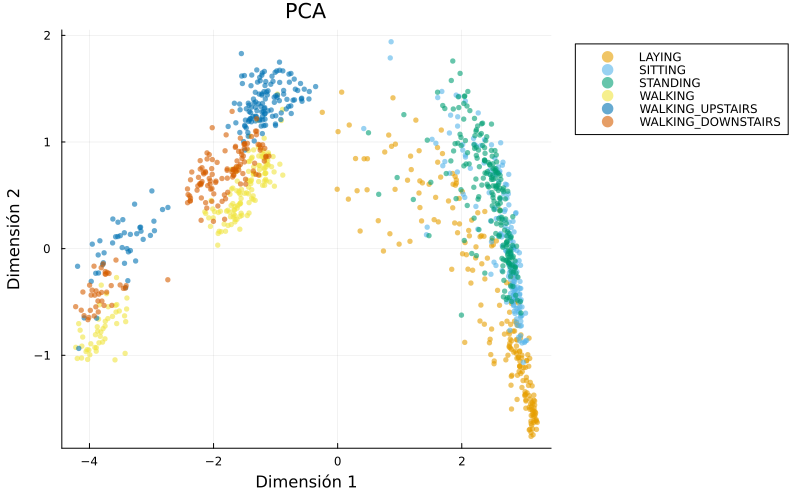

In [24]:
proyector = get_pca_model(; outdim=2)
SCALER = MinMaxScaler()
x_new = generate_2d_projection(SCALER, proyector, X_train, y_train, X_test)
p_2d = plot_2d_projection(x_new, y_test; title="PCA")
display(p_2d)  

### **ICA**

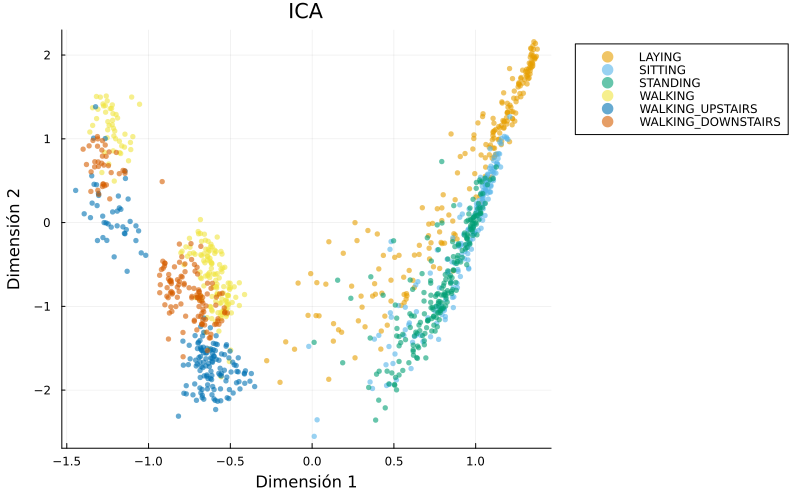

In [25]:
proyector = get_ica_model(; outdim=2, maxiter=10000, do_whiten=true, tol=1e-4)
x_new = generate_2d_projection(SCALER, proyector, X_train, y_train, X_test)
ica_2d = plot_2d_projection(x_new, y_test; title="ICA")
display(ica_2d)  

### **LDA**

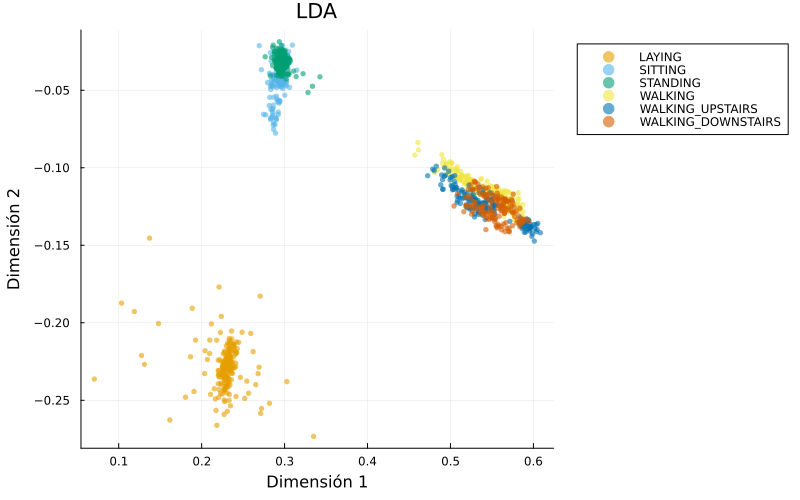

In [26]:
proyector = get_lda_model(; outdim=2)
x_new = generate_2d_projection(SCALER, proyector, X_train, y_train, X_test)
lda_2d = plot_2d_projection(x_new, y_test; title="LDA")
display(lda_2d)  

### **t-SNE**

### **Isomap**

### **LLE**

## **Entrenamiento y evaluación de clasificadores**

Procederemos ahora al entrenamiento de los modelos. Sin embargo antes, debemos instanciar y definir **objetos** y **funciones** que nos servirán durante los **experimentos**.

- Crear el **normalizador** y las **métricas** que usaremos durante todos los experimentos.
- Definiremos la función **run_experiments_cv** ejecutar escenarios de experimentos con **crossvalidation** de manera secilla, **almacenar resultados**, **crear gráficas** y **mostrar tablas**.
- Definiremos la función **run_experiments_holdout** ejecutar escenarios de experimentos con **holdout** de manera secilla, **almacenar resultados**, **crear gráficas** y **mostrar tablas**.

In [18]:
SCALER = MinMaxScaler()
METRICS = Dict(
    "Accuracy" => Accuracy(),
    "F1_Macro" => MulticlassFScore(beta=1.0, average=MacroAvg())
)

Dict{String, StatisticalMeasuresBase.FussyMeasure{M, Nothing} where M} with 2 entries:
  "Accuracy" => Accuracy()
  "F1_Macro" => MulticlassFScore(beta = 1.0, …)

In [19]:
"""
    Ejecutar una serie de escenarios definidos, almacenar resultados, mostrar tablas
    y gráficos de manera automatizada, permite la reutilización de código.
"""

function run_scenarios_cv(scenarios; name:: String="experiment")

    results = History[]

    for (tag, filter, reducer, model) in scenarios
        try
            history = run_experiment_crossvalidation(
                SCALER, 
                filter, 
                reducer, 
                model, 
                X_train, y_train, folds;
                tag = tag, 
                metrics = METRICS
            )

            push!(results, history)
        catch e
            println("Error en el escenario: $tag")
            println(e)
        end
    end

    # Mostrar resultados con métricas predefinidas
    display_cv_table(results, ["Accuracy", "F1_Macro"])

    p = plot_cv_results(results, "F1_Macro", name)
    display(p)

    return results

end

run_scenarios_cv (generic function with 1 method)

In [ ]:
"""
    Ejecutar una serie de escenarios definidos, almacenar resultados, mostrar tablas
    y gráficos de manera automatizada, permite la reutilización de código.
"""

function run_scenarios_holdout(scenarios)

    results = History[]

    for (tag, filter, reducer, model) in scenarios
        try
            history = run_experiment_holdout(
                SCALER, 
                filter, 
                reducer, 
                model, 
                X_train, y_train,
                X_test, y_test;
                tag = tag, 
                metrics = METRICS
            )

            push!(results, history)
        catch e
            println("Error en el escenario: $tag")
            println(e)
        end
    end

    # Mostrar resultados con métricas predefinidas
    display_holdout_table(results, ["Accuracy", "F1_Macro"])

    return results

end

run_scenarios_holdout (generic function with 1 method)

## **Modelos básicos**

Aquí entrenaremos los modelos básicos.

- **Entrenamiento** y **presentación de resultados**.
- Realización de tests de s**ignificancia estadística** y presentación de resultados.

### **1. K Nearest Neighbors**

Exp: KNN_1_ANOVA_PCA   Dims: {505} -> {100.0 ± 0.0} -> {21.4 ± 0.5}   Accuracy: 0.817   F1_Macro: 0.812
Exp: KNN_10_MI_LDA   Dims: {505} -> {100.0 ± 0.0} -> {5.0 ± 0.0}   Accuracy: 0.817   F1_Macro: 0.827
Exp: KNN_20_kendall   Dims: {505} -> {100.0 ± 0.0} -> {100.0 ± 0.0}   Accuracy: 0.745   F1_Macro: 0.756
┌─────────────────┬─────────────────┬────────────────┬─────────────────┬────────────────┐
│ Experiment      │ Accuracy (mean) │ Accuracy (std) │ F1_Macro (mean) │ F1_Macro (std) │
├─────────────────┼─────────────────┼────────────────┼─────────────────┼────────────────┤
│ KNN_10_MI_LDA   │ 0.8170          │ 0.0337         │ 0.8266          │ 0.0320         │
│ KNN_1_ANOVA_PCA │ 0.8166          │ 0.0085         │ 0.8122          │ 0.0099         │
│ KNN_20_kendall  │ 0.7454          │ 0.0093         │ 0.7556          │ 0.0110         │
└─────────────────┴─────────────────┴────────────────┴─────────────────┴────────────────┘


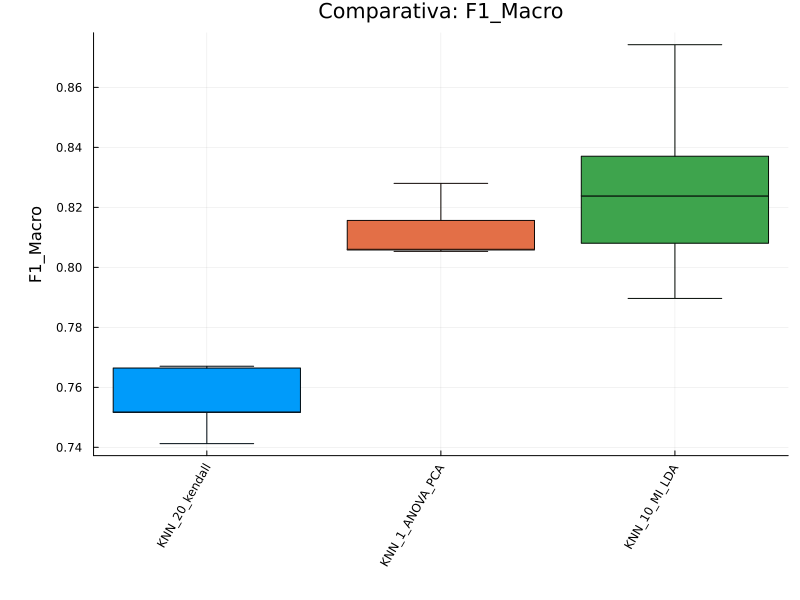

In [20]:
SCENARIOS_KNN = [
    ("KNN_1_ANOVA_PCA", ANOVASelector(k = 100), get_pca_model(pratio=0.95), get_knn_model(1)),
    ("KNN_10_MI_LDA", MutualInfoSelector(k = 100), get_lda_model(outdim=5), get_knn_model(10)),
    ("KNN_20_kendall", KendallSelector(k=100), nothing, get_knn_model(20)), 
]

resuls_knn = run_scenarios_cv(SCENARIOS_KNN, name="knn");

In [24]:
auto_compare_models(resuls_knn, "F1_Macro")


--- Test de Kruskal-Wallis (Global) ---
Hipótesis Nula (H0): Las medianas de los grupos son iguales.
p-value: 0.00752
Resultado: Se rechaza H0 (Diferencias significativas).

--- Comparativa por Pares (Paired T-Test) ---
Referencia: KNN_10_MI_LDA (Media: 0.8266)
┌─────────────────┬────────┬────────────┬─────────┬───────────────┐
│ Modelo          │ Media  │ Diferencia │ P_Value │ Significativo │
├─────────────────┼────────┼────────────┼─────────┼───────────────┤
│ KNN_1_ANOVA_PCA │ 0.8122 │ 0.0144     │ 0.28635 │ No            │
│ KNN_20_kendall  │ 0.7556 │ 0.0709     │ 0.00726 │ Si            │
└─────────────────┴────────┴────────────┴─────────┴───────────────┘



┌ Warning: This test is only asymptotically correct and might be inaccurate for the given group size
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/FtZtp/src/kruskal_wallis.jl:73


### **2. Multilayer Perceptron**

Exp: MLP_[50]_Pearson_PCA   Dims: {505} -> {400.0 ± 0.0} -> {28.8 ± 0.8}   Accuracy: 0.922   F1_Macro: 0.922
Exp: MLP_[100]_Spearman_ICA   Dims: {505} -> {25.0 ± 0.0} -> {10.0 ± 0.0}   Accuracy: 0.659   F1_Macro: 0.668
Exp: MLP_[100, 50]_baseline   Dims: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}   Accuracy: 0.919   F1_Macro: 0.918
┌────────────────────────┬─────────────────┬────────────────┬─────────────────┬────────────────┐
│ Experiment             │ Accuracy (mean) │ Accuracy (std) │ F1_Macro (mean) │ F1_Macro (std) │
├────────────────────────┼─────────────────┼────────────────┼─────────────────┼────────────────┤
│ MLP_[50]_Pearson_PCA   │ 0.9216          │ 0.0146         │ 0.9217          │ 0.0132         │
│ MLP_[100, 50]_baseline │ 0.9193          │ 0.0285         │ 0.9178          │ 0.0302         │
│ MLP_[100]_Spearman_ICA │ 0.6591          │ 0.0385         │ 0.6680          │ 0.0435         │
└────────────────────────┴─────────────────┴────────────────┴─────────────────┴────────

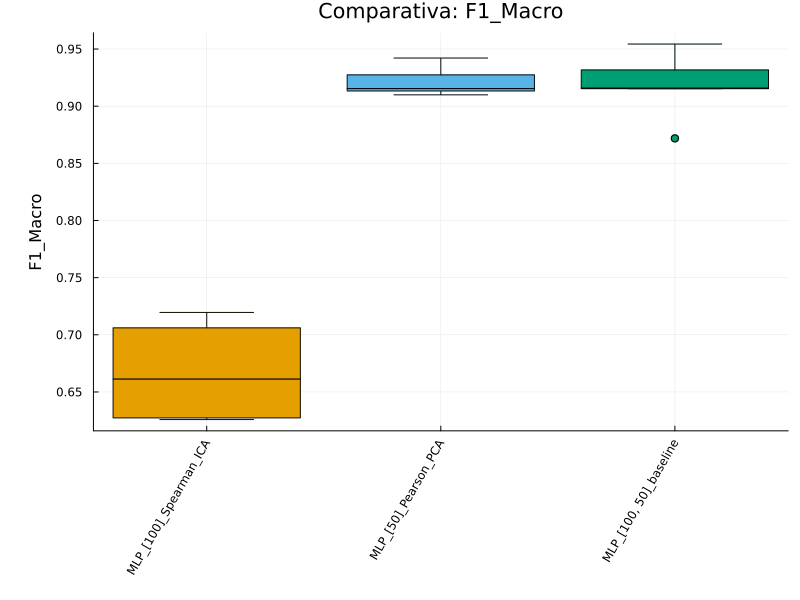

In [32]:
SCENARIOS_MLP = [
    ("MLP_[50]_Pearson_PCA", PearsonSelector(k = 400), get_pca_model(pratio=0.95), get_mlp_model([50]; epochs=30)),
    ("MLP_[100]_Spearman_ICA", SpearmanSelector(k = 25), get_ica_model(outdim=10, maxiter=10000, tol=0.5), get_mlp_model([100]; epochs=30)),
    ("MLP_[100, 50]_baseline", nothing, nothing, get_mlp_model([100, 50]; epochs=30)), 
]

results_mlp = run_scenarios_cv(SCENARIOS_MLP; name="mlp");

In [33]:
auto_compare_models(results_mlp, "F1_Macro")


--- Test de Kruskal-Wallis (Global) ---
Hipótesis Nula (H0): Las medianas de los grupos son iguales.
p-value: 0.009
Resultado: Se rechaza H0 (Diferencias significativas).

--- Comparativa por Pares (Paired T-Test) ---
Referencia: MLP_[50]_Pearson_PCA (Media: 0.9217)
┌────────────────────────┬────────┬────────────┬─────────┬───────────────┐
│ Modelo                 │ Media  │ Diferencia │ P_Value │ Significativo │
├────────────────────────┼────────┼────────────┼─────────┼───────────────┤
│ MLP_[100, 50]_baseline │ 0.9178 │ 0.0038     │ 0.75905 │ No            │
│ MLP_[100]_Spearman_ICA │ 0.6680 │ 0.2536     │ 0.00016 │ Si            │
└────────────────────────┴────────┴────────────┴─────────┴───────────────┘



┌ Warning: This test is only asymptotically correct and might be inaccurate for the given group size
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/FtZtp/src/kruskal_wallis.jl:73


### **3. Suport Vector Machine**

Exp: SVM_01_RFE_LDA   Dims: {505} -> {100.0 ± 0.0} -> {5.0 ± 0.0}   Accuracy: 0.888   F1_Macro: 0.877
Exp: SVM_05_PEARSON_PCA   Dims: {505} -> {250.0 ± 0.0} -> {8.0 ± 0.0}   Accuracy: 0.881   F1_Macro: 0.878
Exp: SVM_1_MI_PCA   Dims: {505} -> {400.0 ± 0.0} -> {79.2 ± 2.5}   Accuracy: 0.934   F1_Macro: 0.934
┌────────────────────┬─────────────────┬────────────────┬─────────────────┬────────────────┐
│ Experiment         │ Accuracy (mean) │ Accuracy (std) │ F1_Macro (mean) │ F1_Macro (std) │
├────────────────────┼─────────────────┼────────────────┼─────────────────┼────────────────┤
│ SVM_1_MI_PCA       │ 0.9340          │ 0.0182         │ 0.9340          │ 0.0177         │
│ SVM_01_RFE_LDA     │ 0.8876          │ 0.0589         │ 0.8766          │ 0.0833         │
│ SVM_05_PEARSON_PCA │ 0.8813          │ 0.0283         │ 0.8777          │ 0.0285         │
└────────────────────┴─────────────────┴────────────────┴─────────────────┴────────────────┘


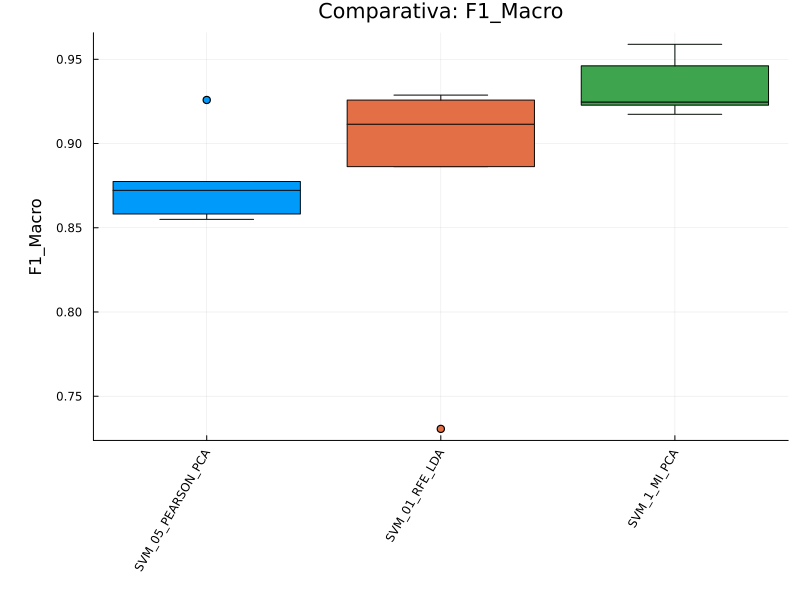

In [22]:
SCENARIOS_SVM = [
    ("SVM_01_RFE_LDA", RFELogistic(k = 100, step=0.5), get_lda_model(outdim=5), get_svm_model(0.1)),
    ("SVM_05_PEARSON_PCA", PearsonSelector(k = 250), get_pca_model(pratio=0.95), get_svm_model(0.5)),
    ("SVM_1_MI_PCA", MutualInfoSelector(k = 400), get_pca_model(pratio=0.98), get_svm_model(1.0)), 
]

results_svm = run_scenarios_cv(SCENARIOS_SVM; name="svm");

In [23]:
auto_compare_models(results_svm, "F1_Macro")


--- Test de Kruskal-Wallis (Global) ---
Hipótesis Nula (H0): Las medianas de los grupos son iguales.
p-value: 0.10228
Resultado: No se rechaza H0.



┌ Warning: This test is only asymptotically correct and might be inaccurate for the given group size
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/FtZtp/src/kruskal_wallis.jl:73


## **Modelos de ensemble básicos**

Aquí entrenaremos los **ensembles básicos** con crossvalidation.

- Presentaremos resultados (tablas y gráficos).
- Realizaremos tests de **significancia estadística**.

### **1. Bagging con kNN**

Exp: BAGGING_KNN_10   Dims: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}   Accuracy: 0.899   F1_Macro: 0.898
Exp: BAGGING_KNN_50   Dims: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}   Accuracy: 0.906   F1_Macro: 0.905
Exp: BAGGING_KNN_PCA_10   Dims: {505} -> {505.0 ± 0.0} -> {64.4 ± 0.9}   Accuracy: 0.893   F1_Macro: 0.892
Exp: BAGGING_KNN_PCA_50   Dims: {505} -> {505.0 ± 0.0} -> {64.4 ± 0.9}   Accuracy: 0.898   F1_Macro: 0.898
┌────────────────────┬─────────────────┬────────────────┬─────────────────┬────────────────┐
│ Experiment         │ Accuracy (mean) │ Accuracy (std) │ F1_Macro (mean) │ F1_Macro (std) │
├────────────────────┼─────────────────┼────────────────┼─────────────────┼────────────────┤
│ BAGGING_KNN_50     │ 0.9055          │ 0.0102         │ 0.9048          │ 0.0113         │
│ BAGGING_KNN_10     │ 0.8992          │ 0.0111         │ 0.8985          │ 0.0119         │
│ BAGGING_KNN_PCA_50 │ 0.8985          │ 0.0104         │ 0.8977          │ 0.0115         │
│ BAGGING_KNN_PCA_10

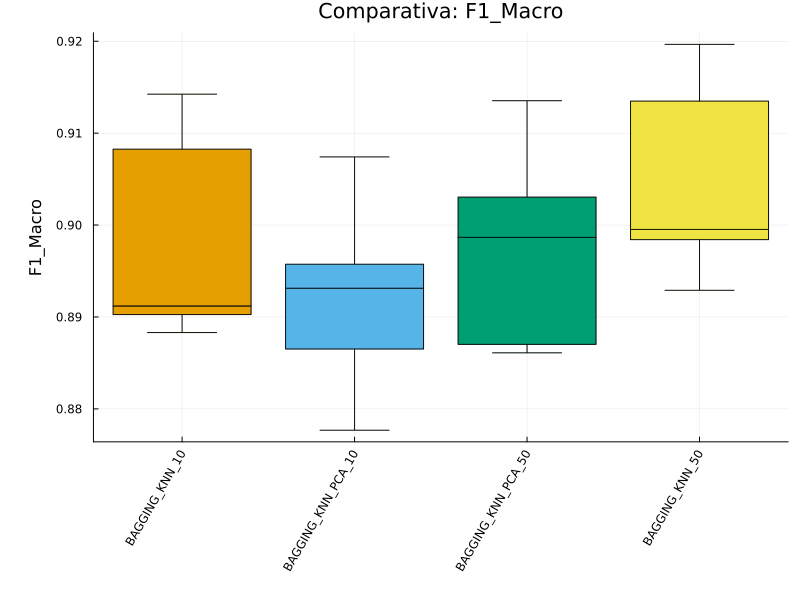

In [38]:
SCENARIOS_BAGGING = [
    ("BAGGING_KNN_10", nothing, nothing, get_bagging_knn_model(5, 10; fraction=0.7)),
    ("BAGGING_KNN_50", nothing, nothing, get_bagging_knn_model(5, 50; fraction=0.5)),
    ("BAGGING_KNN_PCA_10", nothing, get_pca_model(pratio=0.95), get_bagging_knn_model(5, 10; fraction=0.7)),
    ("BAGGING_KNN_PCA_50", nothing, get_pca_model(pratio=0.95), get_bagging_knn_model(5, 50; fraction=0.5))
]

resuls_bagging = run_scenarios_cv(SCENARIOS_BAGGING; name="bagging");

In [45]:
auto_compare_models(resuls_bagging, "F1_Macro")


--- Test de Kruskal-Wallis (Global) ---
Hipótesis Nula (H0): Las medianas de los grupos son iguales.
p-value: 0.42444
Resultado: No se rechaza H0.



### **2. AdaBoost con Decision Trees**

Exp: ADABOOST_50   Dims: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}   Accuracy: 0.702   F1_Macro: 0.639
Exp: ADABOOST_50_PCA   Dims: {505} -> {505.0 ± 0.0} -> {64.4 ± 0.9}   Accuracy: 0.65   F1_Macro: 0.624
Exp: ADABOOST_100   Dims: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}   Accuracy: 0.705   F1_Macro: 0.648
Exp: ADABOOST_100_PCA   Dims: {505} -> {505.0 ± 0.0} -> {64.4 ± 0.9}   Accuracy: 0.631   F1_Macro: 0.624
Exp: ADABOOST_200   Dims: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}   Accuracy: 0.694   F1_Macro: 0.623
Exp: ADABOOST_200_PCA   Dims: {505} -> {505.0 ± 0.0} -> {64.4 ± 0.9}   Accuracy: 0.7   F1_Macro: 0.68
┌──────────────────┬─────────────────┬────────────────┬─────────────────┬────────────────┐
│ Experiment       │ Accuracy (mean) │ Accuracy (std) │ F1_Macro (mean) │ F1_Macro (std) │
├──────────────────┼─────────────────┼────────────────┼─────────────────┼────────────────┤
│ ADABOOST_100     │ 0.7053          │ 0.0707         │ 0.6481          │ 0.0904         │
│ ADABOOST_50      │ 

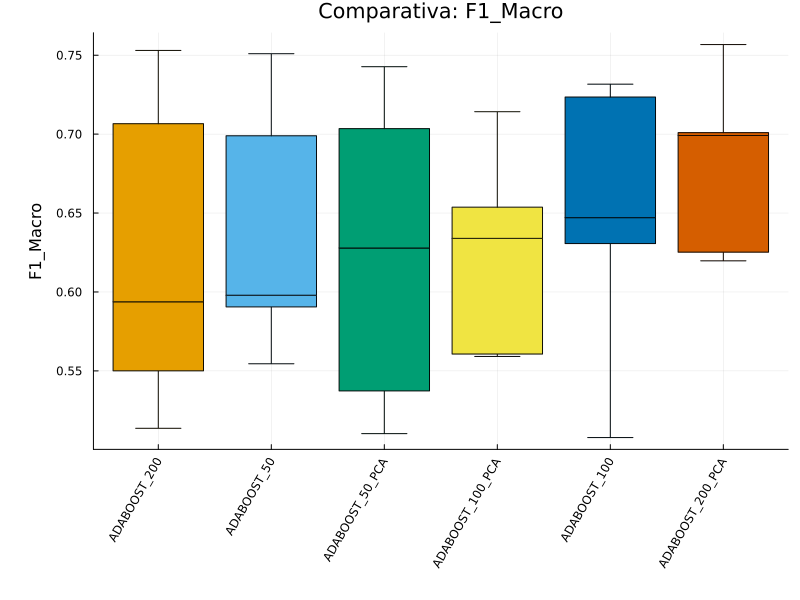

In [40]:
SCENARIOS_ADABOOST = [
    ("ADABOOST_50", nothing, nothing, get_adaboost_model(50)),
    ("ADABOOST_50_PCA", nothing, get_pca_model(pratio=0.95), get_adaboost_model(50)),
    ("ADABOOST_100", nothing, nothing, get_adaboost_model(100)),
    ("ADABOOST_100_PCA", nothing, get_pca_model(pratio=0.95), get_adaboost_model(100)),
    ("ADABOOST_200", nothing, nothing, get_adaboost_model(200)),
    ("ADABOOST_200_PCA", nothing, get_pca_model(pratio=0.95), get_adaboost_model(200))
]

results_adaboost = run_scenarios_cv(SCENARIOS_ADABOOST; name="adaboost");

In [44]:
auto_compare_models(results_adaboost, "F1_Macro")


--- Test de Kruskal-Wallis (Global) ---
Hipótesis Nula (H0): Las medianas de los grupos son iguales.
p-value: 0.92118
Resultado: No se rechaza H0.



### **3. EvoTree (Gradient Boosting)**

Exp: EVOTREE_50   Dims: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}   Accuracy: 0.919   F1_Macro: 0.918
Exp: EVOTREE_100   Dims: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}   Accuracy: 0.927   F1_Macro: 0.927
Exp: EVOTREE_50_PCA   Dims: {505} -> {505.0 ± 0.0} -> {64.4 ± 0.9}   Accuracy: 0.863   F1_Macro: 0.862
Exp: EVOTREE_100_PCA   Dims: {505} -> {505.0 ± 0.0} -> {64.4 ± 0.9}   Accuracy: 0.884   F1_Macro: 0.883
┌─────────────────┬─────────────────┬────────────────┬─────────────────┬────────────────┐
│ Experiment      │ Accuracy (mean) │ Accuracy (std) │ F1_Macro (mean) │ F1_Macro (std) │
├─────────────────┼─────────────────┼────────────────┼─────────────────┼────────────────┤
│ EVOTREE_100     │ 0.9270          │ 0.0157         │ 0.9267          │ 0.0155         │
│ EVOTREE_50      │ 0.9186          │ 0.0148         │ 0.9182          │ 0.0147         │
│ EVOTREE_100_PCA │ 0.8838          │ 0.0202         │ 0.8829          │ 0.0205         │
│ EVOTREE_50_PCA  │ 0.8632          │ 0.0234        

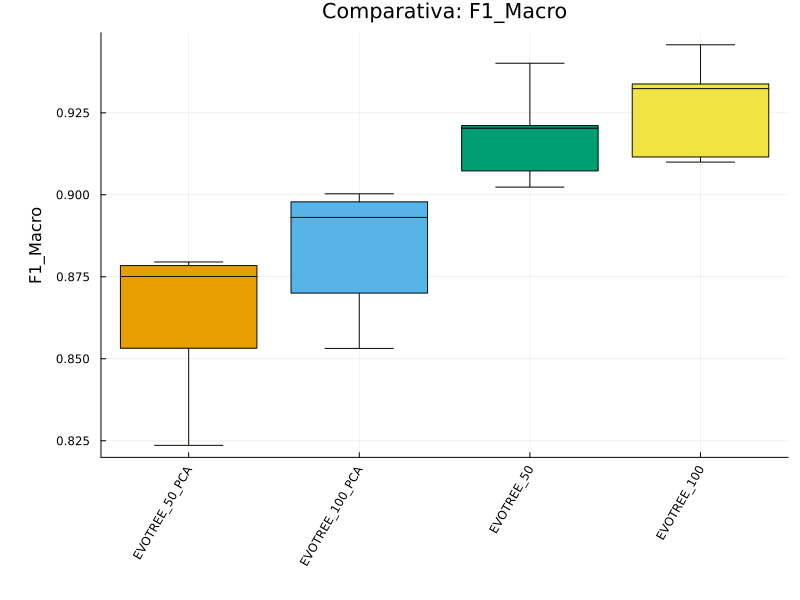

In [42]:
SCENARIOS_EVOTREE = [
    ("EVOTREE_50", nothing, nothing, get_evotree_model(50)),
    ("EVOTREE_100", nothing, nothing, get_evotree_model(100)),
    ("EVOTREE_50_PCA", nothing, get_pca_model(pratio=0.95), get_evotree_model(50)),
    ("EVOTREE_100_PCA", nothing, get_pca_model(pratio=0.95), get_evotree_model(100))
]   

results_evotree = run_scenarios_cv(SCENARIOS_EVOTREE; name="evotree");

In [43]:
auto_compare_models(results_evotree, "F1_Macro")                                      


--- Test de Kruskal-Wallis (Global) ---
Hipótesis Nula (H0): Las medianas de los grupos son iguales.
p-value: 0.00194
Resultado: Se rechaza H0 (Diferencias significativas).

--- Comparativa por Pares (Paired T-Test) ---
Referencia: EVOTREE_100 (Media: 0.9267)
┌─────────────────┬────────┬────────────┬─────────┬───────────────┐
│ Modelo          │ Media  │ Diferencia │ P_Value │ Significativo │
├─────────────────┼────────┼────────────┼─────────┼───────────────┤
│ EVOTREE_50      │ 0.9182 │ 0.0085     │ 0.00755 │ Si            │
│ EVOTREE_100_PCA │ 0.8829 │ 0.0438     │ 0.03001 │ Si            │
│ EVOTREE_50_PCA  │ 0.8620 │ 0.0647     │ 0.01241 │ Si            │
└─────────────────┴────────┴────────────┴─────────┴───────────────┘



## **Entrenamiento con holdout modelos básicos**

En base a los resultados anteriores y sus **tests de significancia estadística**:

- Entrenaremos sobre el **conjunto entero** los siguientes modelos.

### **1. kNN + ANOVA + PCA**

Exp: KNN_1_ANOVA_PCA   Dims: {505} -> {100} -> {22}   Accuracy: 0.7989   F1_Macro: 0.7729
┌─────────────────┬──────────┬──────────┐
│ Experiment      │ Accuracy │ F1_Macro │
├─────────────────┼──────────┼──────────┤
│ KNN_1_ANOVA_PCA │ 0.7989   │ 0.7729   │
└─────────────────┴──────────┴──────────┘


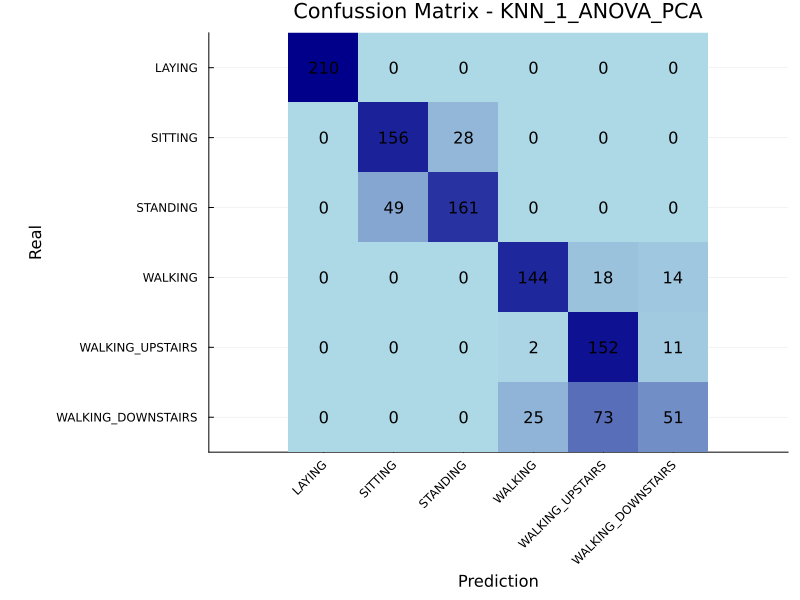

In [20]:
SCENARIO_FINAL_KNN = [
    ("KNN_1_ANOVA_PCA", ANOVASelector(k = 100), get_pca_model(pratio=0.95), get_knn_model(1))
]

results_final_knn = run_scenarios_holdout(SCENARIO_FINAL_KNN);

confussion_matrix = results_final_knn[1].confussion_matrix
tag = results_final_knn[1].name
class_labels = levels(y_test)
class_counts = [count(x -> x == l, y_test) for l in class_labels]
display_confussion_matrix(confussion_matrix, class_labels, class_counts, tag)

### **2. Multilayer perceptron + Pearson + PCA**

Exp: MLP_[50]_Pearson_PCA   Dims: {505} -> {400} -> {29}   Accuracy: 0.9022   F1_Macro: 0.8911
┌──────────────────────┬──────────┬──────────┐
│ Experiment           │ Accuracy │ F1_Macro │
├──────────────────────┼──────────┼──────────┤
│ MLP_[50]_Pearson_PCA │ 0.9022   │ 0.8911   │
└──────────────────────┴──────────┴──────────┘


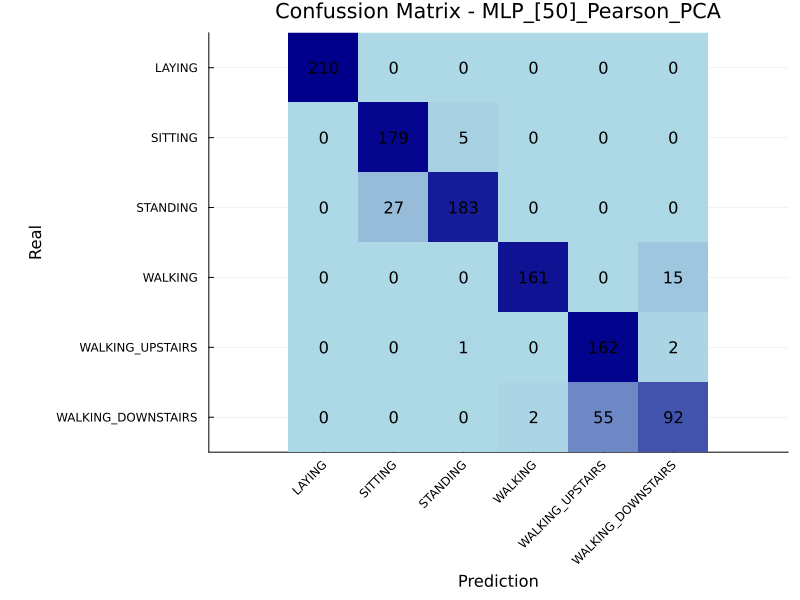

In [28]:
SCENARIO_FINAL_MLP = [
    ("MLP_[50]_Pearson_PCA", PearsonSelector(k = 400), get_pca_model(pratio=0.95), get_mlp_model([50]; epochs=30))
]

results_final_mlp = run_scenarios_holdout(SCENARIO_FINAL_MLP);

confussion_matrix = results_final_mlp[1].confussion_matrix
tag = results_final_mlp[1].name
display_confussion_matrix(confussion_matrix, class_labels, class_counts, tag)


### **3. SVM + Pearson + PCA**

Exp: SVM_05_PEARSON_PCA   Dims: {505} -> {250} -> {8}   Accuracy: 0.8483   F1_Macro: 0.8191
┌────────────────────┬──────────┬──────────┐
│ Experiment         │ Accuracy │ F1_Macro │
├────────────────────┼──────────┼──────────┤
│ SVM_05_PEARSON_PCA │ 0.8483   │ 0.8191   │
└────────────────────┴──────────┴──────────┘


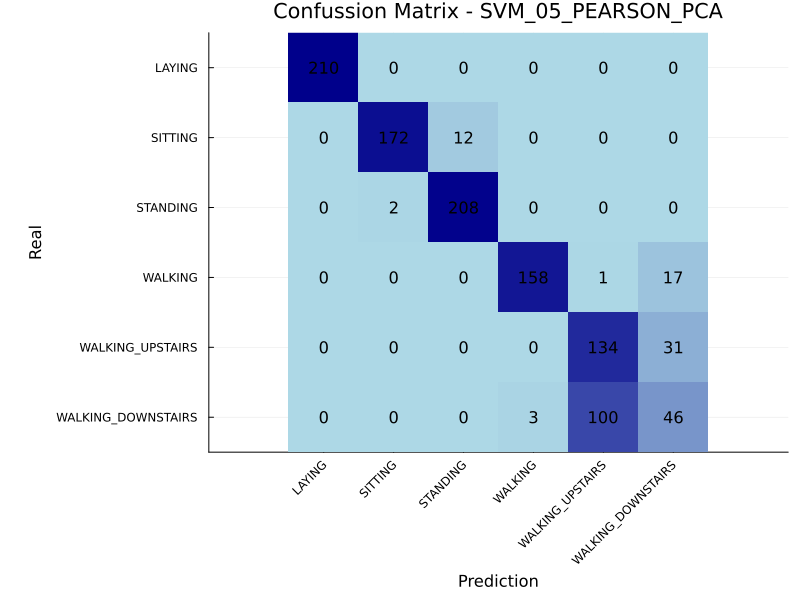

In [29]:
SCENARIO_FINAL_SVM = [
    ("SVM_05_PEARSON_PCA", PearsonSelector(k = 250), get_pca_model(pratio=0.95), get_svm_model(0.5))
]

results_final_svm = run_scenarios_holdout(SCENARIO_FINAL_SVM);

confussion_matrix = results_final_svm[1].confussion_matrix
tag = results_final_svm[1].name
display_confussion_matrix(confussion_matrix, class_labels, class_counts, tag)

### **4. Bagging kNN**

Exp: BAGGING_KNN_10   Dims: {505} -> {505} -> {505}   Accuracy: 0.872   F1_Macro: 0.8452
┌────────────────┬──────────┬──────────┐
│ Experiment     │ Accuracy │ F1_Macro │
├────────────────┼──────────┼──────────┤
│ BAGGING_KNN_10 │ 0.8720   │ 0.8452   │
└────────────────┴──────────┴──────────┘


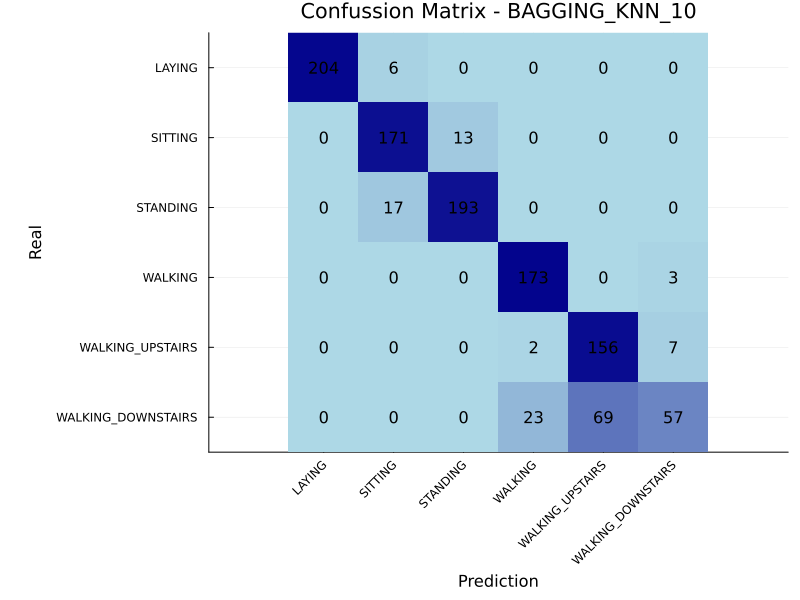

In [30]:
SCENARIOS_BAGGING_FINAL = [
    ("BAGGING_KNN_10", nothing, nothing, get_bagging_knn_model(5, 10; fraction=0.7))
]

results_final_bagging = run_scenarios_holdout(SCENARIOS_BAGGING_FINAL);

confussion_matrix = results_final_bagging[1].confussion_matrix
tag = results_final_bagging[1].name
display_confussion_matrix(confussion_matrix, class_labels, class_counts, tag)

### **5. Adaboost + PCA**

Exp: ADABOOST_50_PCA   Dims: {505} -> {505} -> {65}   Accuracy: 0.5046   F1_Macro: 0.4215
┌─────────────────┬──────────┬──────────┐
│ Experiment      │ Accuracy │ F1_Macro │
├─────────────────┼──────────┼──────────┤
│ ADABOOST_50_PCA │ 0.5046   │ 0.4215   │
└─────────────────┴──────────┴──────────┘


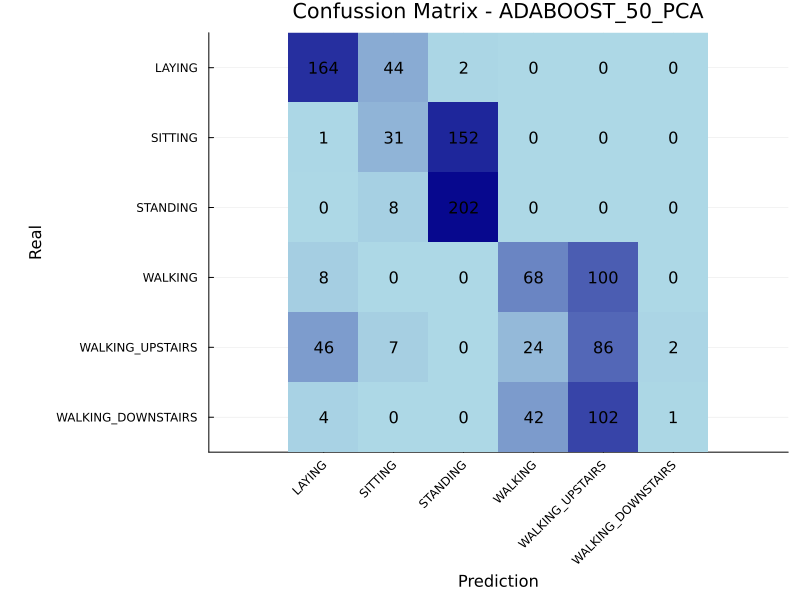

In [31]:
SCENARIOS_ADABOOST_FINAL = [
    ("ADABOOST_50_PCA", nothing, get_pca_model(pratio=0.95), get_adaboost_model(50))
]

results_final_adaboost = run_scenarios_holdout(SCENARIOS_ADABOOST_FINAL);

confussion_matrix = results_final_adaboost[1].confussion_matrix
tag = results_final_adaboost[1].name
display_confussion_matrix(confussion_matrix, class_labels, class_counts, tag)

### **6. Evotree**

Exp: EVOTREE_100   Dims: {505} -> {505} -> {505}   Accuracy: 0.8711   F1_Macro: 0.8468
┌─────────────┬──────────┬──────────┐
│ Experiment  │ Accuracy │ F1_Macro │
├─────────────┼──────────┼──────────┤
│ EVOTREE_100 │ 0.8711   │ 0.8468   │
└─────────────┴──────────┴──────────┘


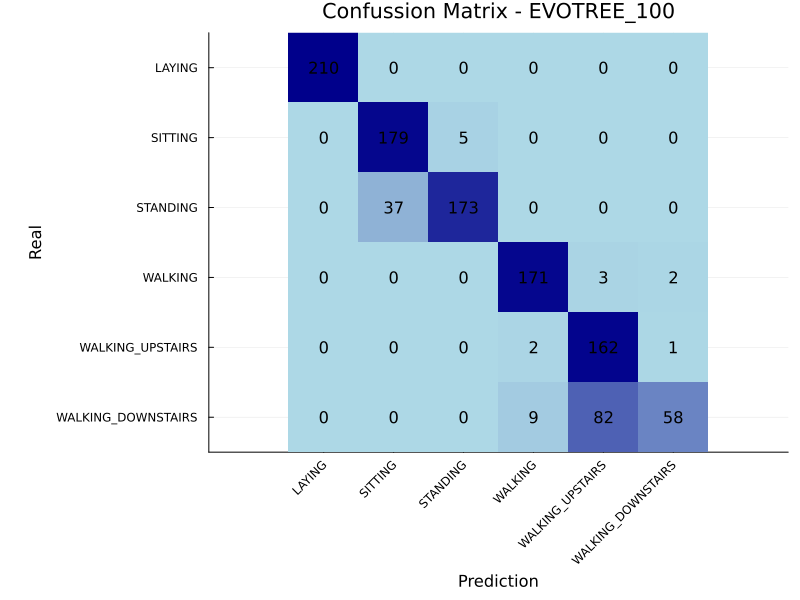

In [32]:
SCENARIOS_EVOTREE_FINAL = [
    ("EVOTREE_100", nothing, nothing, get_evotree_model(100))
]

results_final_evotree = run_scenarios_holdout(SCENARIOS_EVOTREE_FINAL);

confussion_matrix = results_final_evotree[1].confussion_matrix
tag = results_final_evotree[1].name
display_confussion_matrix(confussion_matrix, class_labels, class_counts, tag)

## **Modelos de Ensemble Avanzado**

### **1. Random Forest**

Exp: RANDOM_FOREST   Dims: {505} -> {505} -> {505}   Accuracy: 0.8693   F1_Macro: 0.8437
┌───────────────┬──────────┬──────────┐
│ Experiment    │ Accuracy │ F1_Macro │
├───────────────┼──────────┼──────────┤
│ RANDOM_FOREST │ 0.8693   │ 0.8437   │
└───────────────┴──────────┴──────────┘


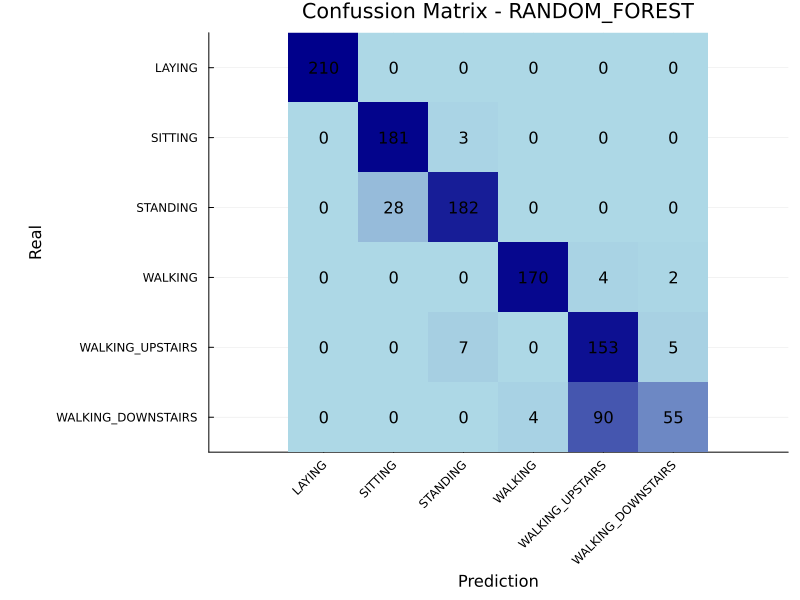

In [22]:
SCENARIOS_RF = [
    ("RANDOM_FOREST", nothing, nothing, get_rf_model(500, 10))
]

results_rf = run_scenarios_holdout(SCENARIOS_RF);

confussion_matrix = results_rf[1].confussion_matrix
tag = results_rf[1].name
class_labels = levels(y_test)
class_counts = [count(x -> x == l, y_test) for l in class_labels]
display_confussion_matrix(confussion_matrix, class_labels, class_counts, tag)

  Col. 1                       Col. 2 

  Total Features                  505
  Features muertas (0.0)            0
  Info explicada por Top-20   36.23 %
  Features para el 50%             35
  Features para el 75%             80
  Features para el 90%            159


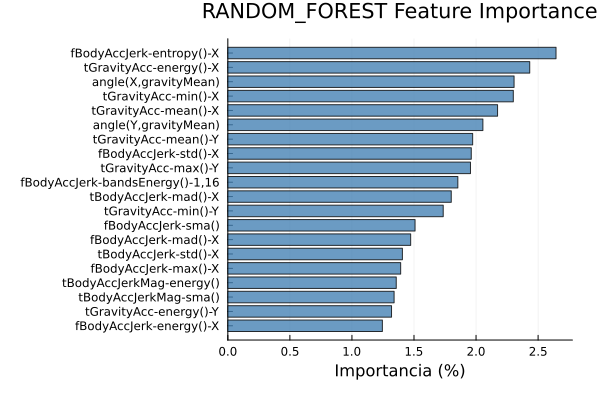

In [23]:
fi = results_rf[1].feature_importances
tag = results_rf[1].name
process_feature_importance(fi, tag)

### **2. XG Boost**

Exp: XG_BOOST   Dims: {505} -> {505} -> {505}   Accuracy: 0.9186   F1_Macro: 0.9039
┌────────────┬──────────┬──────────┐
│ Experiment │ Accuracy │ F1_Macro │
├────────────┼──────────┼──────────┤
│ XG_BOOST   │ 0.9186   │ 0.9039   │
└────────────┴──────────┴──────────┘


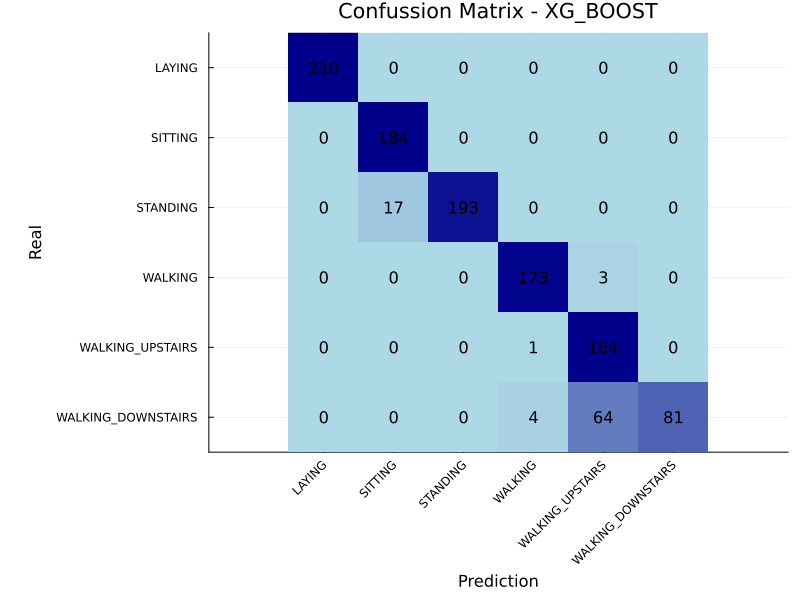

In [23]:
SCENARIOS_XG_BOOST = [
    ("XG_BOOST", nothing, nothing, get_xgboost_model(500))
]

results_xg_boost = run_scenarios_holdout(SCENARIOS_XG_BOOST);

confussion_matrix = results_xg_boost[1].confussion_matrix
tag = results_xg_boost[1].name
display_confussion_matrix(confussion_matrix, class_labels, class_counts, tag)

  Col. 1                       Col. 2 

  Total Features                  421
  Features muertas (0.0)            0
  Info explicada por Top-20   64.35 %
  Features para el 50%             11
  Features para el 75%             32
  Features para el 90%             86


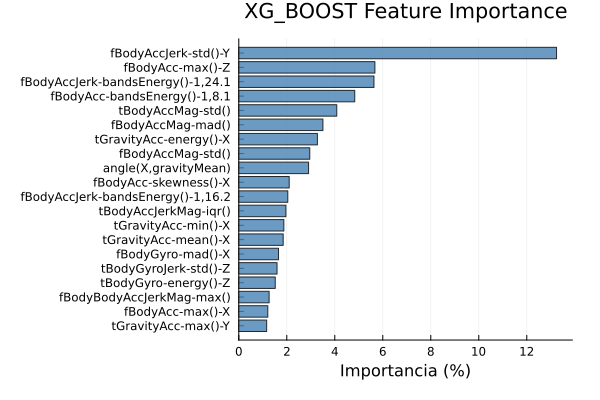

In [24]:
fi = results_xg_boost[1].feature_importances
tag = results_xg_boost[1].name
process_feature_importance(fi, tag)

### **3. LightGBM**

Exp: LGBM   Dims: {505} -> {505} -> {505}   Accuracy: 0.8976   F1_Macro: 0.8833
┌────────────┬──────────┬──────────┐
│ Experiment │ Accuracy │ F1_Macro │
├────────────┼──────────┼──────────┤
│ LGBM       │ 0.8976   │ 0.8833   │
└────────────┴──────────┴──────────┘


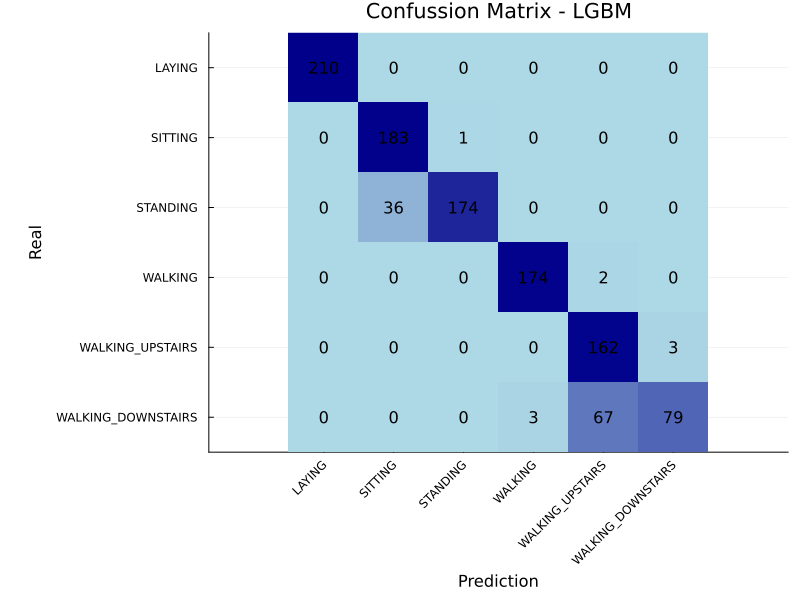

In [24]:
SCENARIOS_LGBM = [
    ("LGBM", nothing, nothing, get_lightgbm_model(100))
]

results_lgbm = run_scenarios_holdout(SCENARIOS_LGBM);

confussion_matrix = results_lgbm[1].confussion_matrix
tag = results_lgbm[1].name
display_confussion_matrix(confussion_matrix, class_labels, class_counts, tag)

### **4. CatBoost**

Debido a **incompatibilidades** con **PythonCall**, Catboost no ha podido ser ejecutado; se ha consierado necesario hacer las siguientes aclaraciones:

- Se ha creado el factory para el modelo en **ModelFactory.jl**.
- Se ha demostrado con demos que el error reside en la conversión de datos de julia a **numpy**.
- Los siguientes ejemplos provienen de la librería Catboost, por lo que se puede verificar la corrección del código.
- https://juliaai.github.io/MLJ.jl/dev/models/CatBoostClassifier_CatBoost/
- https://github.com/JuliaAI/CatBoost.jl
- https://github.com/JuliaAI/CatBoost.jl/blob/main/examples/mlj/multiclass.jl

In [35]:
SCENARIOS_CAT_BOOST = [
    ("CAT_BOOST", nothing, nothing, get_catboost_model())
]

results_cat_boost = run_scenarios_holdout(SCENARIOS_CAT_BOOST);

LoadError: UndefVarError: `MLJ_CatBoost` not defined in `Main.ModelFactory`
Suggestion: check for spelling errors or missing imports.

In [39]:
using CatBoost.MLJCatBoostInterface
using DataFrames
using MLJBase

# Initialize data
train_data = DataFrame([coerce(["a", "a", "c"], MLJBase.Multiclass),
                        coerce(["b", "b", "d"], MLJBase.Multiclass),
                        coerce([0, 0, 1], MLJBase.OrderedFactor), [4, 5, 40], [5, 6, 50],
                        [6, 7, 60]], :auto)
train_labels = coerce([1, 0, -1], MLJBase.Multiclass)
eval_data = DataFrame([coerce(["a", "a"], MLJBase.Multiclass),
                       coerce(["b", "d"], MLJBase.Multiclass), [2, 1], [4, 4], [6, 50],
                       [8, 60]], :auto)

# Initialize CatBoostClassifier
model = CatBoostClassifier(; iterations=2, learning_rate=1, depth=2)
mach = machine(model, train_data, train_labels)

# Fit model
MLJBase.fit!(mach)

# Get predicted classes
preds_class = MLJBase.predict_mode(mach, eval_data)

# Get predicted probabilities for each class
preds_proba = MLJBase.predict(mach, eval_data)

LoadError: Python: ValueError: NoneType copy mode not allowed.
[0mPython stacktrace:
[0m [1] [0m[1m__array__[22m
[90m   @ [39m[90m~/.julia/packages/PythonCall/wkBj7/src/JlWrap/array.jl:371[39m
[0m [2] [0m[1m__new__[22m
[90m   @ [39m[35mpandas.core.indexes.base [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/indexes/base.py:529[39m
[0m [3] [0m[1m_with_infer[22m
[90m   @ [39m[35mpandas.core.indexes.base [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/indexes/base.py:681[39m
[0m [4] [0m[1mvalidate_categories[22m
[90m   @ [39m[35mpandas.core.dtypes.dtypes [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/dtypes/dtypes.py:572[39m
[0m [5] [0m[1m_finalize[22m
[90m   @ [39m[35mpandas.core.dtypes.dtypes [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/dtypes/dtypes.py:378[39m
[0m [6] [0m[1m__init__[22m
[90m   @ [39m[35mpandas.core.dtypes.dtypes [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/dtypes/dtypes.py:221[39m
[0m [7] [0m[1m_from_values_or_dtype[22m
[90m   @ [39m[35mpandas.core.dtypes.dtypes [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/dtypes/dtypes.py:338[39m
[0m [8] [0m[1mfrom_codes[22m
[90m   @ [39m[35mpandas.core.arrays.categorical [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/arrays/categorical.py:746[39m

In [37]:
using CatBoost.MLJCatBoostInterface
using MLJ

X = (
    duration = [1.5, 4.1, 5.0, 6.7], 
    n_phone_calls = [4, 5, 6, 7], 
    department = coerce(["acc", "ops", "acc", "ops"], Multiclass), 
)
y = coerce([0, 0, 1, 1], Multiclass)

model = CatBoostClassifier(iterations=5)
mach = machine(model, X, y)
fit!(mach)
probs = predict(mach, X)
preds = predict_mode(mach, X)


LoadError: Python: ValueError: NoneType copy mode not allowed.
[0mPython stacktrace:
[0m [1] [0m[1m__array__[22m
[90m   @ [39m[90m~/.julia/packages/PythonCall/wkBj7/src/JlWrap/array.jl:371[39m
[0m [2] [0m[1m__new__[22m
[90m   @ [39m[35mpandas.core.indexes.base [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/indexes/base.py:529[39m
[0m [3] [0m[1m_with_infer[22m
[90m   @ [39m[35mpandas.core.indexes.base [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/indexes/base.py:681[39m
[0m [4] [0m[1mvalidate_categories[22m
[90m   @ [39m[35mpandas.core.dtypes.dtypes [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/dtypes/dtypes.py:572[39m
[0m [5] [0m[1m_finalize[22m
[90m   @ [39m[35mpandas.core.dtypes.dtypes [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/dtypes/dtypes.py:378[39m
[0m [6] [0m[1m__init__[22m
[90m   @ [39m[35mpandas.core.dtypes.dtypes [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/dtypes/dtypes.py:221[39m
[0m [7] [0m[1m_from_values_or_dtype[22m
[90m   @ [39m[35mpandas.core.dtypes.dtypes [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/dtypes/dtypes.py:338[39m
[0m [8] [0m[1mfrom_codes[22m
[90m   @ [39m[35mpandas.core.arrays.categorical [39m[90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/arrays/categorical.py:746[39m

### **5. Hard Voting con SVM**

Exp: SVM_VOTING   Dims: {505} -> {505} -> {505}   Accuracy: 0.9077   F1_Macro: 0.8881
┌────────────┬──────────┬──────────┐
│ Experiment │ Accuracy │ F1_Macro │
├────────────┼──────────┼──────────┤
│ SVM_VOTING │ 0.9077   │ 0.8881   │
└────────────┴──────────┴──────────┘


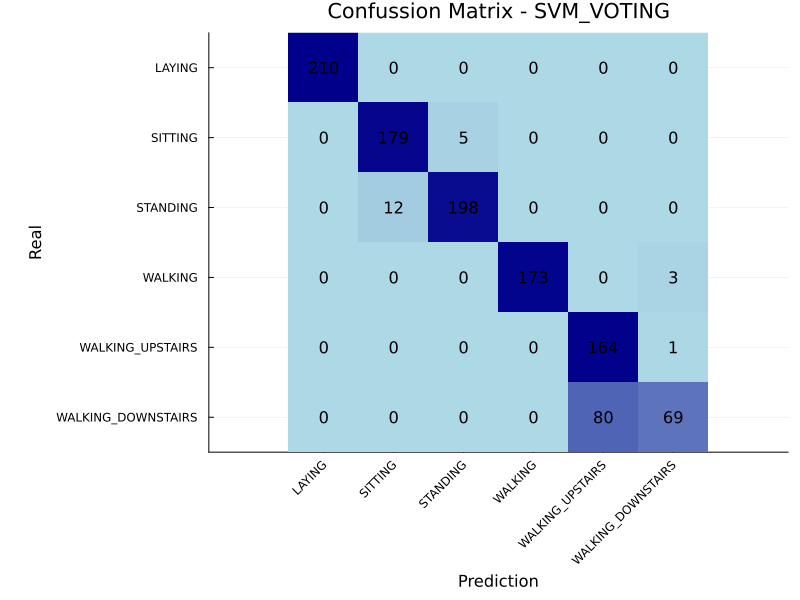

In [24]:
SCENARIOS_SVM_VOTING = [
    ("SVM_VOTING", nothing, nothing, get_voting_classifier(0.5, 3))
]

results_svm_voting = run_scenarios_holdout(SCENARIOS_SVM_VOTING);

confussion_matrix = results_svm_voting[1].confussion_matrix
tag = results_svm_voting[1].name
display_confussion_matrix(confussion_matrix, class_labels, class_counts, tag)

### **6. Stacking Ensemble**

Exp: STACKING_CLASSIFIER   Dims: {505} -> {505} -> {505}   Accuracy: 0.9351   F1_Macro: 0.9242
┌─────────────────────┬──────────┬──────────┐
│ Experiment          │ Accuracy │ F1_Macro │
├─────────────────────┼──────────┼──────────┤
│ STACKING_CLASSIFIER │ 0.9351   │ 0.9242   │
└─────────────────────┴──────────┴──────────┘


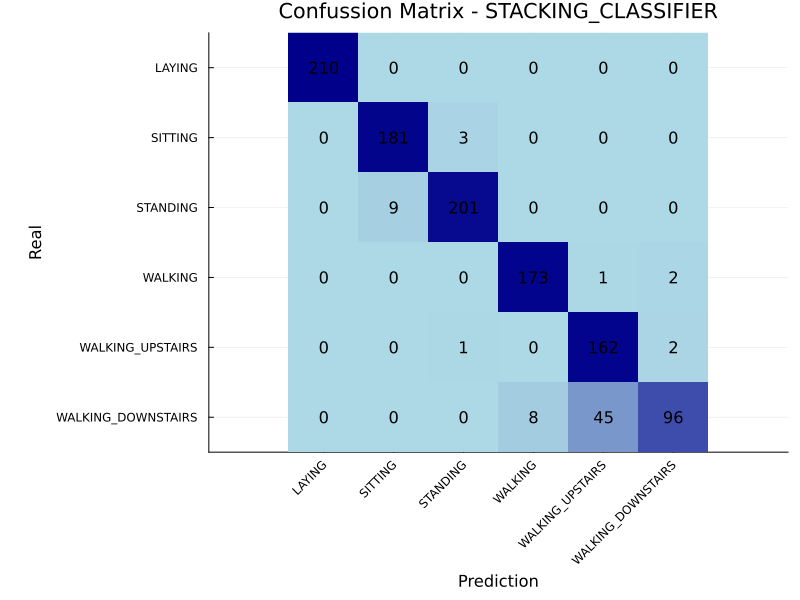

In [26]:
base_models = Dict(
    :knn => get_knn_model(1),
    :svm => get_svm_model(0.5),
    :mlp => get_mlp_model([50]; epochs=30)
)

meta_learner = get_mlp_model([20]; epochs=20)

resampling_strategy = IndividualWiseCV(folds)

stacking_model = get_stacking_model(meta_learner,
                                    base_models, 
                                    resampling_strategy)

SCENARIOS_STACKING = [
    ("STACKING_CLASSIFIER", nothing, nothing, stacking_model)
]
results_stacking = run_scenarios_holdout(SCENARIOS_STACKING);

confussion_matrix = results_stacking[1].confussion_matrix
tag = results_stacking[1].name
display_confussion_matrix(confussion_matrix, class_labels, class_counts, tag)

## **Tabla final comparativa**

In [34]:
all_models_holdout = vcat(
    results_final_adaboost,
    results_final_bagging,
    results_final_evotree,
    results_final_knn,
    results_final_mlp,
    results_final_svm,
    results_rf,
    results_xg_boost,
    results_lgbm,
    results_svm_voting,
    results_stacking
)

display_holdout_table(all_models_holdout, ["Accuracy", "F1_Macro"]);

┌──────────────────────┬──────────┬──────────┐
│ Experiment           │ Accuracy │ F1_Macro │
├──────────────────────┼──────────┼──────────┤
│ STACKING_CLASSIFIER  │ 0.9351   │ 0.9242   │
│ XG_BOOST             │ 0.9186   │ 0.9039   │
│ SVM_VOTING           │ 0.9086   │ 0.8898   │
│ MLP_[50]_Pearson_PCA │ 0.9022   │ 0.8911   │
│ LGBM                 │ 0.8976   │ 0.8833   │
│ RANDOM_FOREST        │ 0.8729   │ 0.8470   │
│ BAGGING_KNN_10       │ 0.8720   │ 0.8452   │
│ EVOTREE_100          │ 0.8711   │ 0.8468   │
│ SVM_05_PEARSON_PCA   │ 0.8483   │ 0.8191   │
│ KNN_1_ANOVA_PCA      │ 0.7989   │ 0.7729   │
│ ADABOOST_50_PCA      │ 0.5046   │ 0.4215   │
└──────────────────────┴──────────┴──────────┘
